## Loading sakila database into duckdb

In [48]:
import duckdb

#### Register the data
Connecting to the database and open the file, export the description to dataframe to see the information in the database, loop through the tables in 'description' and get the data to then register the dataframes in duckdb.

In [49]:
dfs = {}

#open and close file safely 
with duckdb.connect("data/sakila.duckdb") as conn:
    description = conn.sql("DESC;").df()

    for name in description["name"]:
        if name[0] != '_':
            dfs[name] = conn.sql(f"FROM staging.{name};").df()

            duckdb.register(name, dfs[name])

### Which movies are longer than 3 hours (180 minutes)?

In [50]:
longer_than_three_hours = duckdb.sql("""
            SELECT
                title,
                length || ' minutes' AS length
            FROM
                film
            WHERE
                length > 180;            
""").df()
longer_than_three_hours.index = longer_than_three_hours.index + 1

longer_than_three_hours.head(3)

,title,length
1,ANALYZE HOOSIERS,181 minutes
2,BAKED CLEOPATRA,182 minutes
3,CATCH AMISTAD,183 minutes


### Which movies have the word "love" in its title?
- Searching for LOVE by it self, not inside a word

In [51]:
love_in_title = duckdb.sql("""
            SELECT
                title,
                rating,
                length || ' minutes' AS length,
                description
            FROM
                film
            WHERE
                regexp_matches (title, '\\bLOVE\\b');                            
""").df()
# Tip from Felix to use double \ to make regexp work in python
love_in_title.index = love_in_title.index + 1

love_in_title

,title,rating,length,description
1,GRAFFITI LOVE,PG,117 minutes,A Unbelieveable Epistle of a Sumo Wrestler And...
2,IDAHO LOVE,PG-13,172 minutes,A Fast-Paced Drama of a Student And a Crocodil...
3,INDIAN LOVE,NC-17,135 minutes,A Insightful Saga of a Mad Scientist And a Mad...
4,LAWRENCE LOVE,NC-17,175 minutes,A Fanciful Yarn of a Database Administrator An...
5,LOVE SUICIDES,R,181 minutes,A Brilliant Panorama of a Hunter And a Explore...


### Statistics on the length of the movies
- Shortest
- Average
- Median
- Longest


In [52]:
length_statistics = duckdb.sql("""
            SELECT
                MIN(length)::int || ' minutes' AS shortest_movie,
                ROUND(AVG(length))::int || ' minutes' AS average_movie,
                MEDIAN(length)::int || ' minutes' AS median_movie,
                MAX(length)::int || ' minutes' AS longest_movie
            FROM
                film;
""").df()
length_statistics.index = length_statistics.index + 1

length_statistics

,shortest_movie,average_movie,median_movie,longest_movie
1,46 minutes,115 minutes,114 minutes,185 minutes


### Most expensive movies to rent per day
- Several movies have the same rate as these once

In [53]:
most_expensive_movies = duckdb.sql("""
            SELECT  
                title,                                
                ROUND(rental_rate / rental_duration, 2) || ' $' AS rate_per_day
            FROM
                film
            GROUP BY rate_per_day, title
            ORDER BY
                rate_per_day DESC, title ASC
            LIMIT 10;
""").df()
most_expensive_movies.index = most_expensive_movies.index + 1

most_expensive_movies.head(3)

,title,rate_per_day
1,ACE GOLDFINGER,1.66 $
2,AMERICAN CIRCUS,1.66 $
3,AUTUMN CROW,1.66 $


### Which actors have played in most movies?
- Several actors have played in 35 movies
- Order by name to get same result each time

In [54]:
actor_most_movies = duckdb.sql("""
            SELECT 
                a.first_name || ' ' || a.last_name AS actor_name,
                COUNT(DISTINCT fa.film_id) AS number_of_movies
            FROM actor a
                LEFT JOIN film_actor fa ON a.actor_id = fa.actor_id
            GROUP BY actor_name
            ORDER BY 
                    number_of_movies DESC,
                    actor_name ASC
            LIMIT 10;
            """).df()
actor_most_movies.index = actor_most_movies.index + 1

actor_most_movies.head(3)

,actor_name,number_of_movies
1,SUSAN DAVIS,54
2,GINA DEGENERES,42
3,WALTER TORN,41


### Which movies have a revenue less than three dollars?

In [55]:
less_than_three_dollars = duckdb.sql("""
            SELECT
                DISTINCT f.title,
                ROUND(SUM(rental_rate),2) || ' $' AS film_revenue    
            FROM 
                film f
                LEFT JOIN inventory i ON f.film_id = i.film_id
                LEFT JOIN rental r ON r.inventory_id = i.inventory_id
            GROUP BY f.title
            HAVING film_revenue < '3'
            ORDER BY film_revenue ASC, title ASC;
""").df()
less_than_three_dollars.index = less_than_three_dollars.index +1

less_than_three_dollars.head(3)

,title,film_revenue
1,ALICE FANTASIA,0.99 $
2,ARGONAUTS TOWN,0.99 $
3,ARK RIDGEMONT,0.99 $


### Times categories have been rented and their revenue

In [56]:
category_rental_rate_and_revenue = duckdb.sql("""
            SELECT
                DISTINCT c.name,
                COUNT(rental_rate) AS times_rented,
                ROUND(SUM(p.amount),2) || ' $' AS revenue_per_category,
            FROM 
                film f
                LEFT JOIN inventory i ON f.film_id = i.film_id
                LEFT JOIN rental r ON r.inventory_id = i.inventory_id
                LEFT JOIN film_category fc ON fc.film_id = f.film_id
                LEFT JOIN category c ON c.category_id = fc.category_id
                LEFT JOIN payment p ON p.rental_id = r.rental_id
            GROUP BY  c.name
            ORDER BY times_rented DESC, revenue_per_category DESC;
""").df()
category_rental_rate_and_revenue.index = category_rental_rate_and_revenue.index +1

category_rental_rate_and_revenue.head(3)

,name,times_rented,revenue_per_category
1,Sports,1180,5314.21 $
2,Animation,1168,4656.3 $
3,Action,1115,4375.85 $


### Each stores amount of movies, their revenue and the average revenue per movie

In [57]:
store_inventory_revenue = duckdb.sql("""
            SELECT
                distinct i.store_id,
                COUNT(DISTINCT i.inventory_id) AS store_inventory,
                ROUND(SUM(p.amount),2) AS store_revenue,
                ROUND(store_revenue/store_inventory, 2) || ' $' AS average_revenue_per_movie
            FROM inventory i
                LEFT JOIN rental r ON r.inventory_id = i.inventory_id
                LEFT JOIN payment p ON p.rental_id = r.rental_id
            GROUP BY i.store_id
            ORDER BY i.store_id;
""").df()
store_inventory_revenue.index = store_inventory_revenue.index +1

store_inventory_revenue

,store_id,store_inventory,store_revenue,average_revenue_per_movie
1,1,2270,33679.79,14.84 $
2,2,2311,33726.77,14.59 $


### Who are our top 5 customers by total spend? 

In [58]:
top_paying_customers = duckdb.sql("""
            SELECT
                DISTINCT c.first_name || ' ' || c.last_name AS customer_name,
                ROUND(SUM(p.amount),2) AS amount
            FROM
                customer c
                LEFT JOIN payment p ON c.customer_id = p.customer_id
            GROUP BY customer_name
            ORDER BY amount DESC
            LIMIT 5;
""").df()

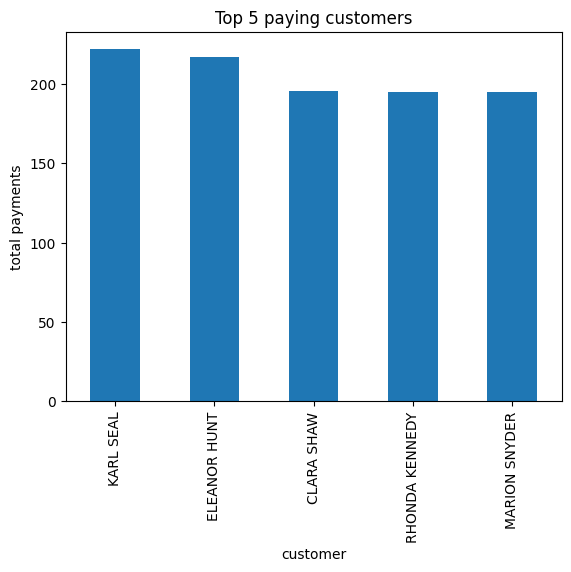

In [59]:
ax = top_paying_customers.plot(kind="bar", x="customer_name", y="amount", xlabel="customer", ylabel="total payments", title="Top 5 paying customers", legend=False)

###  How much money does each film category bring in? 

In [60]:
category_revenue = duckdb.sql("""
            SELECT
                DISTINCT c.name,
                SUM(p.amount) AS amount
            FROM category c
                LEFT JOIN film_category fc ON c.category_id = fc.category_id
                LEFT JOIN inventory i ON fc.film_id = i.film_id
                LEFT JOIN rental r ON r.inventory_id = i.inventory_id
                LEFT JOIN payment p ON p.rental_id = r.rental_id
            GROUP BY c.name
            ORDER BY amount DESC;
""").df()

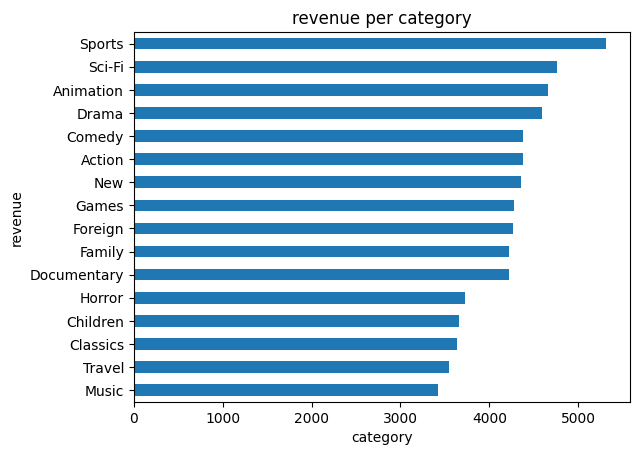

In [61]:
ax = category_revenue.plot(kind="barh", x="name", y="amount", xlabel="category", ylabel="revenue", title="revenue per category", legend=False)
ax.invert_yaxis()